In [117]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [118]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS = 3
EPOCHS=20


In [119]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [120]:
class_names=dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


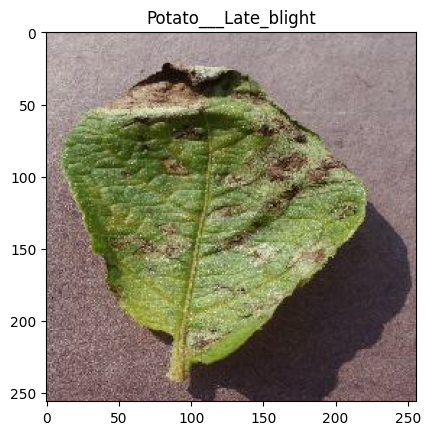

In [121]:
for image_batch,label_batch in dataset.take(1):
    plt.title(class_names[label_batch[0]])
    plt.imshow(image_batch[0].numpy().astype("uint8"))

In [122]:
print(len(dataset))

68


In [123]:
trainsize= 0.8
trainds=dataset.take(54)
len(trainds)

54

In [124]:
testds=dataset.skip(54)
len(testds)

14

In [125]:
valid=0.1
valds=testds.take(6)
len(valds)

6

In [126]:
testds=testds.skip(6)
len(testds)

8

In [127]:
def get_ds_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size =int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return trainds,valds,testds


In [128]:
train_ds,val_ds,test_ds= get_ds_partitions_tf(dataset)
len(train_ds)

54

In [129]:
len(val_ds)

6

In [130]:
len(test_ds)

8

In [131]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [132]:
resize_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [133]:
dat_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [134]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

model= models.Sequential([
    resize_rescale,
    dat_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='softmax')
    ])

model.build(input_shape=input_shape)

In [135]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_7 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [136]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics= ['accuracy']
)

In [137]:
tf.config.list_physical_devices('GPU')

[]

In [138]:
histor=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1, 
    validation_data=val_ds
)

Epoch 1/20
54/54 [==============================] - 89s 2s/step - loss: 1.2741 - accuracy: 0.4583 - val_loss: 0.9444 - val_accuracy: 0.5365
Epoch 2/20
54/54 [==============================] - 84s 2s/step - loss: 0.8865 - accuracy: 0.5220 - val_loss: 0.8918 - val_accuracy: 0.6042
Epoch 3/20
54/54 [==============================] - 84s 2s/step - loss: 0.7457 - accuracy: 0.6834 - val_loss: 0.6639 - val_accuracy: 0.7083
Epoch 4/20
54/54 [==============================] - 84s 2s/step - loss: 0.5356 - accuracy: 0.7766 - val_loss: 0.5985 - val_accuracy: 0.7500
Epoch 5/20
54/54 [==============================] - 80s 1s/step - loss: 0.3848 - accuracy: 0.8385 - val_loss: 0.3194 - val_accuracy: 0.8542
Epoch 6/20
54/54 [==============================] - 80s 1s/step - loss: 0.2776 - accuracy: 0.8935 - val_loss: 0.4633 - val_accuracy: 0.8542
Epoch 7/20
54/54 [==============================] - 81s 1s/step - loss: 0.2721 - accuracy: 0.8848 - val_loss: 0.2963 - val_accuracy: 0.8698
Epoch 8/20
54/54 [==

In [139]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 3s 250ms/step - loss: 0.2165 - accuracy: 0.9267


In [140]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 3s 247ms/step - loss: 0.2370 - accuracy: 0.9181


In [141]:
history


def predict(model,img):
    image_array=tf.keras.preprocessing.image.img_to_array(images[i],numpy)
    img_array=tf.expand_dims(img_array,0)

    predictions = model.predict(img_array)
    predictedclass=class_names[np.argmax(batch_prediction[0])]

    confidence=round(100*(np.max(predictions[0])),2)
    return predictedclass,confidence
def predict(model,img):
    image_array=tf.keras.preprocessing.image.img_to_array(images[i],numpy)
    img_array=tf.expand_dims(img_array,0)

    predictions = model.predict(img_array)
    predictedclass=class_names[np.argmax(batch_prediction[0])]

    confidence=round(100*(np.max(predictions[0])),2)
    return predictedclass,confidence
plt.figure(figsize=(15,15))
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS = 3
EPOCHS=20
dataset =tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
   

In [142]:
histor.params


{'verbose': 1, 'epochs': 20, 'steps': 54}

In [143]:
histor.history['accuracy']

[0.4583333432674408,
 0.5219907164573669,
 0.6834490895271301,
 0.7766203880310059,
 0.8385416865348816,
 0.8935185074806213,
 0.8848379850387573,
 0.9114583134651184,
 0.9189814925193787,
 0.9305555820465088,
 0.9415509104728699,
 0.9375,
 0.9542824029922485,
 0.9641203880310059,
 0.9589120149612427,
 0.9594907164573669,
 0.9728009104728699,
 0.9646990895271301,
 0.9739583134651184,
 0.9733796119689941]

first image prediction
actual label: Potato___Early_blight
1/1 [==============================] - 0s 379ms/step
Potato___Early_blight


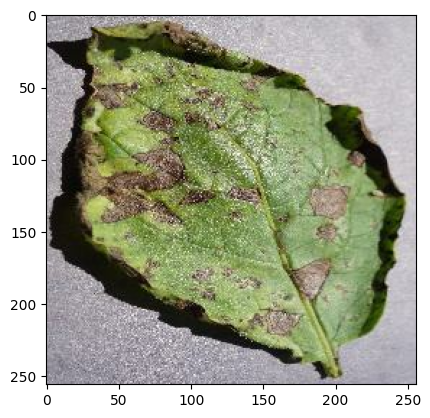

In [144]:
import numpy as np
for image_batch,label_batch in dataset.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()

    print("first image prediction")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction=model.predict(image_batch)
    print(class_names[np.argmax(batch_prediction[0])])
    

In [145]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)

    predictions = model.predict(img_array)
    predictedclass=class_names[np.argmax(batch_prediction[0])]

    confidence=round(100*(np.max(predictions[0])),2)
    return predictedclass,confidence
    
    

1/1 [==============================] - 0s 21ms/step


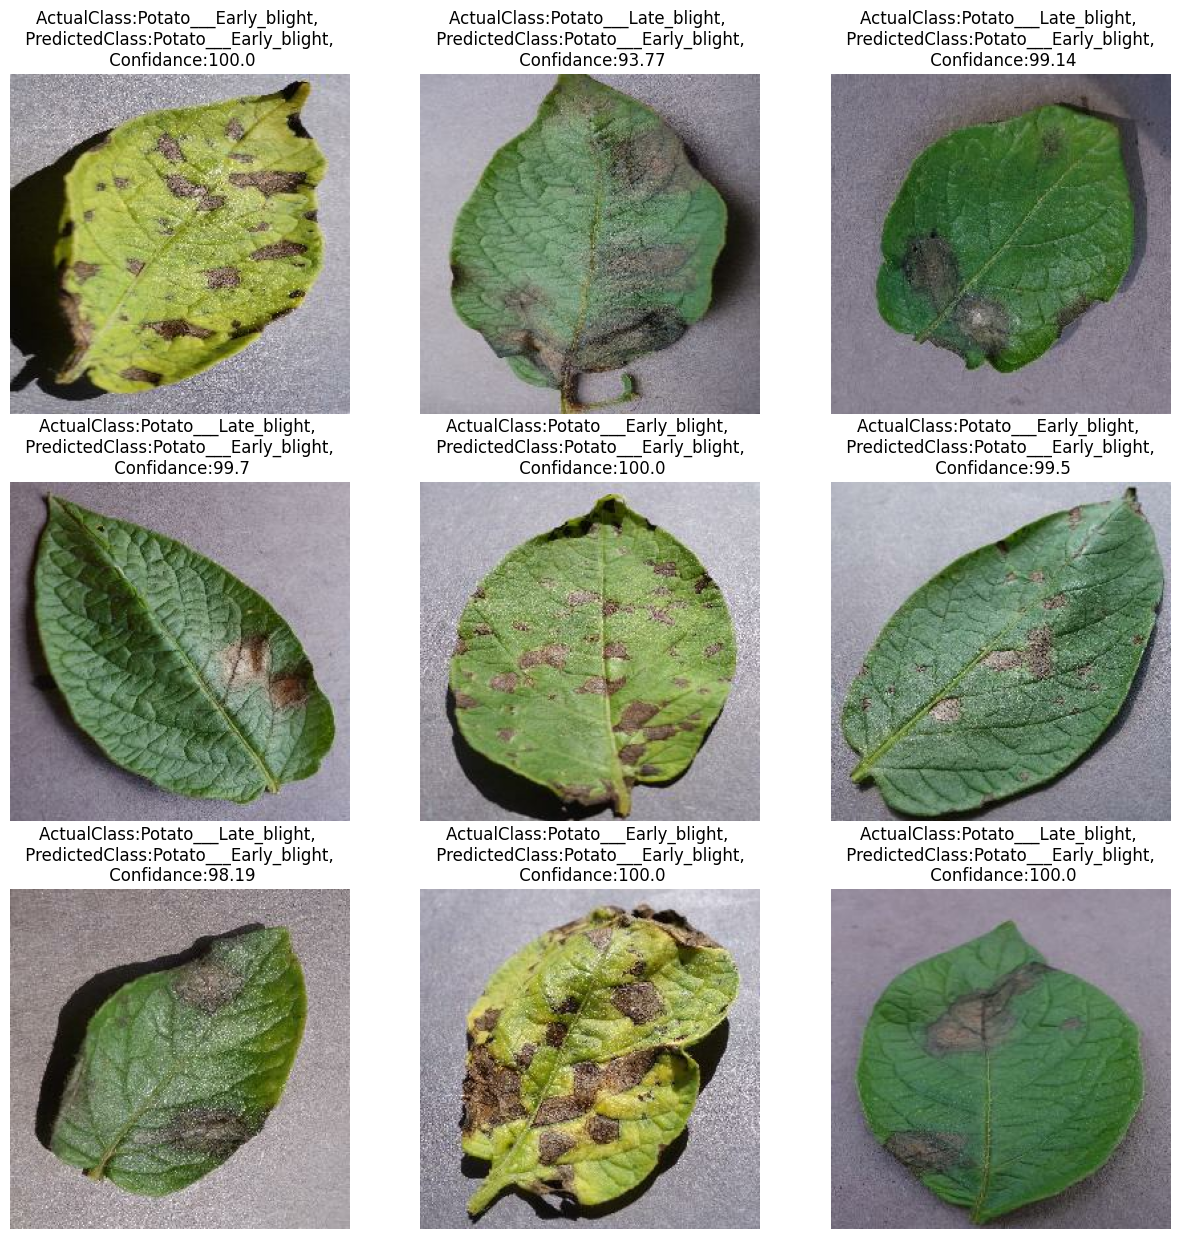

In [149]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"ActualClass:{actual_class}, \n PredictedClass:{predicted_class}, \n Confidance:{confidence}")
        # plt.title("PredictedClass1",predicted_class)
        plt.axis("off")

In [153]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models")+[0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/3\assets


INFO:tensorflow:Assets written to: ../saved_models/3\assets
